<h1 style="font-size:3rem;color:orange;">Directing User Subscriptions</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Training</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import time

### Import Data

In [2]:
df_users = pd.read_csv("data/processed/new_app-user-data.csv")

### Data Peek

In [3]:
df_users.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


# Data Pre-processing

### Remove the label from the features

In [4]:
label = df_users['enrolled']
df_users = df_users.drop(columns = 'enrolled')

### Split the dataset into training and test sets

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users, label,
                                                    test_size = 0.2,
                                                    random_state = 2)
print(X_train.shape)
print(X_test.shape)

(40000, 49)
(10000, 49)


### Filter model data

In [6]:
# Purge user identification, persist to associate the prediction to the user it came from 
train_identifier = X_train['user']
X_train = X_train.drop(columns = ['user'])

test_identifier = X_test['user']
X_test = X_test.drop(columns = ['user'])

### Feature Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

# To normalize features
standard_scaler_X = StandardScaler()

# Scale the training & test datasets, persist results to a new dataframe
X_train2 = pd.DataFrame(standard_scaler_X.fit_transform(X_train))
X_test2 = pd.DataFrame(standard_scaler_X.transform(X_test))

# Retrieve columns for the standardized training & test sets 
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

# Recuperate indexes 
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

# Convert original training set into the new training set
X_train = X_train2
X_test = X_test2

X_train.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,location,Institutions,VerifyPhone,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
5478,1.465294,0.194010,-0.623858,-0.387249,-0.349088,-0.458132,2.249171,0.966559,1.553842,0.953911,...,-0.11851,-0.116211,-0.114989,-0.089944,-0.087075,-0.602852,-0.258576,2.533069,-0.288405,0.315319
22132,0.480735,-0.074669,-0.994774,0.822372,-0.349088,-0.458132,-0.444608,0.966559,-0.643566,0.953911,...,-0.11851,-0.116211,-0.114989,-0.089944,-0.087075,1.030911,-0.258576,-0.759865,-0.288405,0.315319
33533,0.973015,0.865708,0.117975,-0.387249,-0.349088,2.182778,2.249171,-1.034598,1.553842,-1.048316,...,-0.11851,-0.116211,8.696456,-0.089944,-0.087075,-0.058264,-0.258576,0.063368,-0.288405,0.315319
42605,-1.488382,0.865708,-0.345671,0.313058,-0.349088,-0.458132,-0.444608,-1.034598,-0.643566,0.953911,...,-0.11851,-0.116211,-0.114989,-0.089944,-0.087075,0.486323,-0.258576,1.709835,-0.288405,0.315319
48740,0.973015,1.268727,0.952536,6.934141,-0.349088,-0.458132,-0.444608,0.966559,-0.643566,-1.048316,...,-0.11851,-0.116211,-0.114989,-0.089944,-0.087075,-0.058264,-0.258576,0.063368,4.611579,0.315319


# Model Building

## Training

In [8]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Add 'l1' penalty (lasso regularization) for screen correlation
model = LogisticRegression(random_state=2, C=0.1, penalty='l1', solver='liblinear')

# Train the model on the test data
model.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', random_state=2, solver='liblinear')

## Evaluation

Accuracy Score:  0.76160
Precision Score: 0.76319
Recall Score:    0.75954
F1 Score:        0.76136


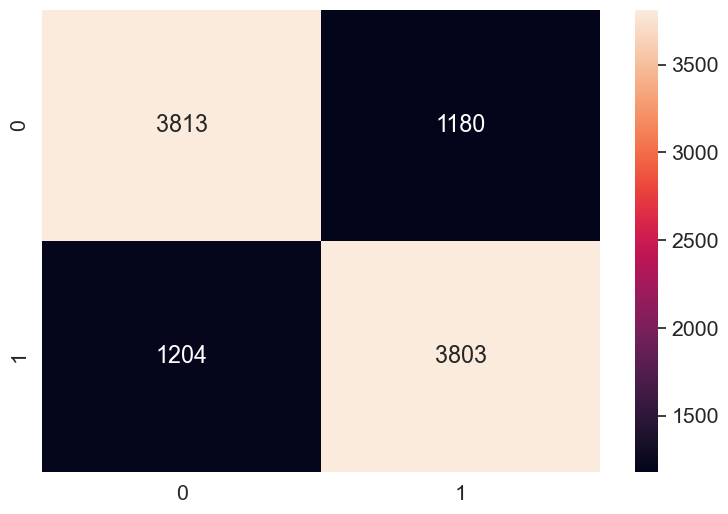

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Make predictions from test set
y_predict = model.predict(X_test)

# Create a confusion matrix with test labels and our model's predictions
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot Matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

# Display Scores
print(f"Accuracy Score:  {accuracy_score(y_test, y_predict):.5f}")  # NumCorrectPredicts / TotalNumPredicts
print(f"Precision Score: {precision_score(y_test, y_predict):.5f}") # TP / (TP + FP)
print(f"Recall Score:    {recall_score(y_test, y_predict):.5f}")    # TP / (TP + FN)
print(f"F1 Score:        {f1_score(y_test, y_predict):.5f}")        # 2 * (precision * recall) / (precision + recall)

### K-Fold Cross Validation

Estimate how well the model is likely to generalize to unseen data

In [10]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

print("Cross Validated Scores Mean: %0.5f Std: (+/- %0.5f)" % (accuracies.mean(), accuracies.std() * 2))

Cross Validated Scores Mean: 0.77118 Std: (+/- 0.00749)


### Analyze Coefficients

In [11]:
# Analyze model coefficients
coefficients = pd.concat([pd.DataFrame(df_users.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(model.coef_), columns = ["coef"])
           ],axis = 1)

# Display (adjust to view all)
coefficients.head()

,features,coef
0,dayofweek,0.023370
1,hour,-0.014571
2,age,-0.147035
3,numscreens,-0.103153
4,minigame,-0.026956


## Model Tuning

#### Grid Search (Round One)

In [12]:
from sklearn.model_selection import GridSearchCV

# Select regularization methods
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()

rf_best_accuracy1 = grid_search.best_score_
rf_best_parameters1 = grid_search.best_params_

print("Round One Time: %0.2f seconds" % (end_time - start_time))
print("Round One Best Accuracy: ", rf_best_accuracy1)
print("Round One Best Parameters: ", rf_best_parameters1)

Round One Time: 23.30 seconds
Round One Best Accuracy:  0.771175
Round One Best Parameters:  {'C': 0.1, 'penalty': 'l1'}


#### Grid Search (Round Two)

In [13]:
# Select regularization methods
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()

rf_best_accuracy2 = grid_search.best_score_
rf_best_parameters2 = grid_search.best_params_

print("Round Two Time: %0.2f seconds" % (end_time - start_time))
print("Round Two Best Accuracy: ", rf_best_accuracy2)
print("Round Two Best Parameters: ", rf_best_parameters2)

Round Two Time: 18.89 seconds
Round Two Best Accuracy:  0.771175
Round Two Best Parameters:  {'C': 0.1, 'penalty': 'l1'}


## Save Model

In [14]:
import os
import pickle

# Create a directory to save the model if it doesn't exist
directory = "model"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to the specified directory
filename = os.path.join(directory, 'sklearn_model.pkl')
with open(filename, 'wb') as file:
    pickle.dump(model, file)